# DSCI552: HW6
#Part 1: Supervised, Semi-Supervised, and Unsupervised Learning


***Name: Cheng Peng***


***USC ID: 6898-9638-37***

#Part 1: Supervised, Semi-Supervised, and Unsupervised Learning

A): Download data and split into training and ttest sets 

In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
url = "/content/drive/My Drive/DSCI552/Homework 6 Data/wdbc.data"
columns = ["feature_{}".format(i) for i in range(1,31)]
columns[0:0] = "ID", "Diagnosis"
df = pd.read_csv(url, names=columns)

In [ ]:
df.head()

,ID,Diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df["Diagnosis"].value_counts()

B    357
M    212
Name: Diagnosis, dtype: int64

In [ ]:
data_df, label_df = df[["feature_{}".format(i) for i in range(1,31)]], df["Diagnosis"]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(data_df, label_df):
    train_x, train_y = data_df.iloc[train_index], label_df.iloc[train_index]
    test_x, test_y = data_df.iloc[test_index], label_df.iloc[test_index]

In [ ]:
test_y.value_counts()

B    72
M    42
Name: Diagnosis, dtype: int64

***Comment:*** 20% of each class is selected as testing set 

B): Monte-Carlo Simulation 

i) Supervised Learning: SVM 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# L1 pentality -> standaridize the data 
scaler = StandardScaler().fit(train_x)
train_x_stand = scaler.transform(train_x)
test_x_stand = scaler.transform(test_x)
#determine the range of C using very large and very small parameters
results = []
c_values = np.linspace(-10,10,21)
for c in c_values:
    model = LinearSVC(penalty='l1', C=10**c, dual=False, random_state=1).fit(train_x_stand, train_y)
    score = model.score(test_x_stand, test_y)
    results.append((c, score))

In [ ]:
results

[(-10.0, 0.631578947368421),
 (-9.0, 0.631578947368421),
 (-8.0, 0.631578947368421),
 (-7.0, 0.631578947368421),
 (-6.0, 0.631578947368421),
 (-5.0, 0.631578947368421),
 (-4.0, 0.631578947368421),
 (-3.0, 0.631578947368421),
 (-2.0, 0.9649122807017544),
 (-1.0, 0.9736842105263158),
 (0.0, 0.9824561403508771),
 (1.0, 0.9824561403508771),
 (2.0, 0.9824561403508771),
 (3.0, 0.9824561403508771),
 (4.0, 0.9824561403508771),
 (5.0, 0.9824561403508771),
 (6.0, 0.9824561403508771),
 (7.0, 0.9824561403508771),
 (8.0, 0.9824561403508771),
 (9.0, 0.9824561403508771),
 (10.0, 0.9824561403508771)]

***Comment:*** choose C from -1 to 3 on the log scale if we set the threshold to 0.97. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# split the data randomly for each iteration of the Monte-Carlo simulation 
def randomSplit(data, label,  test_size = 0.2):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for train_index, test_index in sss.split(data_df, label_df):
        train_x, train_y = data.iloc[train_index], label.iloc[train_index]
        test_x, test_y = data.iloc[test_index], label.iloc[test_index]
    # cast the label, M->1, B->0
    train_y = train_y.apply(lambda x: 1 if x == "M" else 0)
    test_y = test_y.apply(lambda x: 1 if x == "M" else 0)
    return train_x, train_y, test_x, test_y
# standardized data for SVM 
def standardizedData(train_x, test_x):
    scaler = StandardScaler().fit(train_x)
    return scaler.transform(train_x), scaler.transform(test_x)

In [ ]:
# helper function to compute the metrics
def computeResult(x, y, model):
    predict = model.predict(x)
    accuracy = accuracy_score(y, predict)
    precision = precision_score(y, predict)
    recall = recall_score(y, predict)
    f1 = f1_score(y, predict)
    auc = roc_auc_score(y, predict)
    return [accuracy, precision, recall, f1, auc]

In [ ]:
train_results = []
test_results = []

for i in range(30):
    print("Iteration {}: ".format(i+1))
    train_x, train_y, test_x, test_y = randomSplit(data_df, label_df)
    train_x_stand, test_x_stand = standardizedData(train_x, test_x)
    param = {"C":np.logspace(-1, 3, 10)}
    model = LinearSVC(penalty='l1', dual=False)
    grid_search = GridSearchCV(model, param, cv = 5, verbose = 1).fit(train_x_stand, train_y)
    best_model = grid_search.best_estimator_
    best_c = grid_search.best_params_["C"]
    train_result = computeResult(train_x_stand, train_y, best_model)
    test_result = computeResult(test_x_stand, test_y, best_model)
    print("Best C = {:.4f}, train accuracy = {:.4f}, test accuracy = {:.4f}. \n\n".format(best_c,train_result[0], test_result[0]))
    train_results.append(train_result)
    test_results.append(test_result)


Iteration 1: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9912. 


Iteration 2: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9868, test accuracy = 0.9912. 


Iteration 3: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9824, test accuracy = 0.9825. 


Iteration 4: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9824, test accuracy = 0.9649. 


Iteration 5: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9825. 


Iteration 6: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9890, test accuracy = 0.9561. 


Iteration 7: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9824, test accuracy = 0.9737. 


Iteration 8: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9912, test accuracy = 0.9737. 


Iteration 9: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9824, test accuracy = 0.9825. 


Iteration 10: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9825. 


Iteration 11: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9846, test accuracy = 0.9561. 


Iteration 12: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9802, test accuracy = 0.9649. 


Iteration 13: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9890, test accuracy = 0.9474. 


Iteration 14: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9912, test accuracy = 0.9474. 


Iteration 15: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9846, test accuracy = 0.9649. 


Iteration 16: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9825. 


Iteration 17: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9649. 


Iteration 18: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9824, test accuracy = 0.9737. 


Iteration 19: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.7743, train accuracy = 0.9868, test accuracy = 0.9649. 


Iteration 20: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9846, test accuracy = 0.9825. 


Iteration 21: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9824, test accuracy = 0.9912. 


Iteration 22: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9890, test accuracy = 0.9825. 


Iteration 23: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.7743, train accuracy = 0.9890, test accuracy = 0.9737. 


Iteration 24: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9846, test accuracy = 0.9561. 


Iteration 25: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9912, test accuracy = 0.9649. 


Iteration 26: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9868, test accuracy = 0.9737. 


Iteration 27: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9802, test accuracy = 0.9912. 


Iteration 28: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.2783, train accuracy = 0.9912, test accuracy = 0.9649. 


Iteration 29: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9737. 


Iteration 30: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best C = 0.1000, train accuracy = 0.9868, test accuracy = 0.9474. 




[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


In [ ]:
train_table = pd.DataFrame(train_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])
test_table = pd.DataFrame(test_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])

In [ ]:
# report the average of training and test sets 
train_1 = train_table.agg(["mean"])
train_1

,Accuracy,Precision,Recall,F1,AUC
mean,0.986081,0.991802,0.970784,0.981167,0.982994


In [ ]:
test_1 = test_table.agg(["mean"])
test_1

,Accuracy,Precision,Recall,F1,AUC
mean,0.971637,0.979112,0.943651,0.960654,0.965807


In [ ]:
# compute confusion matrix and draw the roc curve 
model = best_model # pick the best_model from the last iteration of the Monte-Carlo simulation 
train_predict = model.predict(train_x_stand) # use the train_x_stand for the last iteration of the Monte-Carlo simulation
test_predict = model.predict(test_x_stand)
train_conf = confusion_matrix(train_y, train_predict)
test_conf = confusion_matrix(test_y, test_predict)

In [ ]:
train_conf = pd.DataFrame(train_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])
train_conf

,Predict B,Predict M
Actual B,283,2
Actual M,4,166


In [ ]:
test_conf = pd.DataFrame(test_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])
test_conf

,Predict B,Predict M
Actual B,71,1
Actual M,5,37


In [ ]:
# roc curve 
# use the decision function of SVM to compute the confidence score for the samples 
train_fp, train_tp, train_thresholds = roc_curve(train_y, model.decision_function(train_x_stand))
test_fp, test_tp, test_thresholds = roc_curve(test_y, model.decision_function(test_x_stand))

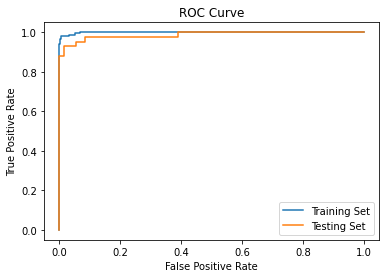

In [ ]:
plt.plot(train_fp, train_tp, label = "Training Set")
plt.plot(test_fp, test_tp, label = "Testing Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

ii): Semi-supervised Learning/Self Training

In [ ]:
train_results = []
test_results = []

for i in range(30):
    print("Iteration {}: ".format(i+1))
    train_x, train_y, test_x, test_y = randomSplit(data_df, label_df)
    train_x_stand, test_x_stand = standardizedData(train_x, test_x)
    train_x_stand = pd.DataFrame(train_x_stand)
    test_x_stand = pd.DataFrame(test_x_stand)
    # split the training data into labeled and unlebeled sets 
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
    for labeled_index, unlabeled_index in sss.split(train_x_stand, train_y):
        labeled_train_x = train_x_stand.iloc[labeled_index]
        labeled_train_y = train_y.iloc[labeled_index]
        unlebeled_train_x = train_x_stand.iloc[unlabeled_index]
        unlebeled_train_y = train_y.iloc[unlabeled_index]
    labeled_train_x.reset_index(inplace = True, drop = True)
    labeled_train_y.reset_index(inplace = True, drop = True)
    unlebeled_train_x.reset_index(inplace = True, drop = True)
    unlebeled_train_y.reset_index(inplace = True, drop = True)
    # Train an L1-penalized SVM to classify the labeled data
    param = {"C":np.logspace(-1, 3, 10)}
    model = LinearSVC(penalty='l1', dual=False)
    grid_search = GridSearchCV(model, param, cv = 5, verbose = 1).fit(labeled_train_x, labeled_train_y)
    best_model = grid_search.best_estimator_
    best_c = grid_search.best_params_["C"]

    while len(unlebeled_train_x)>0:

        distances = best_model.decision_function(unlebeled_train_x)
        distances = [abs(x) for x in distances]
        furthest_index = np.argmax(distances)
        furthest_point = unlebeled_train_x.iloc[furthest_index]
        furthest_predict = best_model.predict(np.array(furthest_point).reshape((1,-1)))
        # add the furthest point to the labeled set
        labeled_train_x = labeled_train_x.append(furthest_point, ignore_index=True)
        furthest_predict = pd.Series(furthest_predict)
        labeled_train_y = labeled_train_y.append(furthest_predict, ignore_index=True)
        # drop the furthest point from the unlabeled set 
        unlebeled_train_x = unlebeled_train_x.drop(furthest_index)
        unlebeled_train_y = unlebeled_train_y.drop(furthest_index)
        unlebeled_train_x.reset_index(inplace = True, drop = True)
        unlebeled_train_y.reset_index(inplace = True, drop = True)
        #retrain the model 
        best_model.fit(labeled_train_x, labeled_train_y)
    train_result = computeResult(train_x_stand, train_y, best_model)
    test_result = computeResult(test_x_stand, test_y, best_model)
    print("Best C = {:.4f}, train accuracy = {:.4f}, test accuracy = {:.4f}. \n\n".format(best_c,train_result[0], test_result[0]))
    train_results.append(train_result)
    test_results.append(test_result)


Iteration 1: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.7743, train accuracy = 0.9692, test accuracy = 0.9386. 


Iteration 2: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.2783, train accuracy = 0.9714, test accuracy = 0.9737. 


Iteration 3: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9736, test accuracy = 0.9912. 


Iteration 4: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.1000, train accuracy = 0.9758, test accuracy = 0.9737. 


Iteration 5: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9736, test accuracy = 0.9737. 


Iteration 6: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9802, test accuracy = 0.9649. 


Iteration 7: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.2783, train accuracy = 0.9758, test accuracy = 0.9649. 


Iteration 8: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.7743, train accuracy = 0.9758, test accuracy = 0.9649. 


Iteration 9: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.2783, train accuracy = 0.9802, test accuracy = 0.9737. 


Iteration 10: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 2.1544, train accuracy = 0.9824, test accuracy = 0.9474. 


Iteration 11: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished


Best C = 0.2783, train accuracy = 0.9780, test accuracy = 0.9561. 


Iteration 12: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9780, test accuracy = 0.9737. 


Iteration 13: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9736, test accuracy = 0.9825. 


Iteration 14: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9758, test accuracy = 0.9649. 


Iteration 15: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


Best C = 0.7743, train accuracy = 0.9846, test accuracy = 0.9298. 


Iteration 16: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 1000.0000, train accuracy = 0.9824, test accuracy = 0.9561. 


Iteration 17: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.2783, train accuracy = 0.9802, test accuracy = 0.9649. 


Iteration 18: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.7743, train accuracy = 0.9802, test accuracy = 0.9561. 


Iteration 19: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.2783, train accuracy = 0.9736, test accuracy = 0.9912. 


Iteration 20: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


Best C = 0.1000, train accuracy = 0.9648, test accuracy = 0.9737. 


Iteration 21: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9692, test accuracy = 0.9737. 


Iteration 22: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9758, test accuracy = 0.9825. 


Iteration 23: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.2783, train accuracy = 0.9736, test accuracy = 0.9561. 


Iteration 24: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.1000, train accuracy = 0.9714, test accuracy = 0.9561. 


Iteration 25: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.2783, train accuracy = 0.9846, test accuracy = 0.9561. 


Iteration 26: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9780, test accuracy = 0.9737. 


Iteration 27: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.7743, train accuracy = 0.9780, test accuracy = 0.9737. 


Iteration 28: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9714, test accuracy = 0.9561. 


Iteration 29: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Best C = 0.1000, train accuracy = 0.9692, test accuracy = 0.9649. 


Iteration 30: 
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished


Best C = 0.2783, train accuracy = 0.9758, test accuracy = 0.9649. 




In [ ]:
train_table = pd.DataFrame(train_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])
test_table = pd.DataFrame(test_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])

In [ ]:
# report the average of training and test sets 
train_2 = train_table.agg(["mean"])
train_2

,Accuracy,Precision,Recall,F1,AUC
mean,0.975897,0.983207,0.951961,0.967195,0.971068


In [ ]:
test_2 = test_table.agg(["mean"])
test_2

,Accuracy,Precision,Recall,F1,AUC
mean,0.965789,0.982229,0.924603,0.952033,0.957209


In [ ]:
# compute confusion matrix and draw the roc curve 
model = best_model # pick the best_model from the last iteration of the Monte-Carlo simulation 
train_predict = model.predict(train_x_stand) # use the train_x_stand for the last iteration of the Monte-Carlo simulation
test_predict = model.predict(test_x_stand)
train_conf = confusion_matrix(train_y, train_predict)
test_conf = confusion_matrix(test_y, test_predict)

In [ ]:
train_conf = pd.DataFrame(train_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])
test_conf = pd.DataFrame(test_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])

In [ ]:
train_conf

,Predict B,Predict M
Actual B,278,7
Actual M,4,166


In [ ]:
test_conf

,Predict B,Predict M
Actual B,69,3
Actual M,1,41


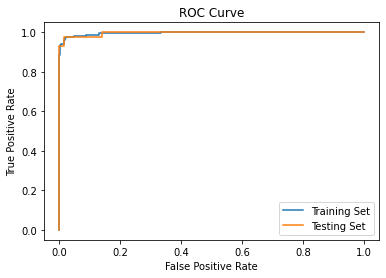

In [ ]:
# roc curve 
# use the decision function of SVM to compute the confidence score for the samples 
train_fp, train_tp, train_thresholds = roc_curve(train_y, model.decision_function(train_x_stand))
test_fp, test_tp, test_thresholds = roc_curve(test_y, model.decision_function(test_x_stand))
plt.plot(train_fp, train_tp, label = "Training Set")
plt.plot(test_fp, test_tp, label = "Testing Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

iii): Unsupervised learning - K-mean

***How to make sure that the algorithm was not trapper in a local minimum?***



Answer: we run the k-mean algorithm multiple time with different random_state in order to make sure the model initalize the cluster centres randomly, thus reduce the chance of it being stuck in a local minimum. For instance, we can set n_init to a higher number or set random_state to a different number each time when we run the algorithm. 

In [ ]:
def kmeanComputeResults(y, predict):
    accuracy = accuracy_score(y, predict)
    precision = precision_score(y, predict)
    recall = recall_score(y, predict)
    f1 = f1_score(y, predict)
    auc = roc_auc_score(y, predict)
    return [accuracy, precision, recall, f1, auc]

In [ ]:
train_results = []
test_results = []
for i in range(30):
    print("Iteration {}: ".format(i+1))
    #A: Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly.
    train_x, train_y, test_x, test_y = randomSplit(data_df, label_df)
    # it is not necessary to normalize the data, but i found it help to improve accuracy rate
    train_x, test_x = standardizedData(train_x, test_x)  
    #convert dataframes to np arries 
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    test_x = np.array(test_x)
    test_y = np.array(test_y)
    model = KMeans(n_clusters=2, random_state=i).fit(train_x)
    # B: find the 30 closest points to the cluster centres 
    centres = model.cluster_centers_
    labels = model.labels_
    distances_one = [np.linalg.norm(train_x[i]-centres[1]) for i in range(len(train_x))]
    distances_zero = [np.linalg.norm(train_x[i]-centres[0]) for i in range(len(train_x))]
    closest_one_index = np.argsort(distances_one)[:30]
    closest_zero_index = np.argsort(distances_zero)[:30]
    # majority polling of each cluster according to the 30 closest points to the centers 
    cluster_one_y = train_y[closest_one_index]
    cluster_zero_y = train_y[closest_zero_index]
    polling_one = np.argmax(np.bincount(cluster_one_y))
    polling_zero = np.argmax(np.bincount(cluster_zero_y))
    # assign label according to majority polling 
    train_predict = []
    for i in range(len(train_x)):
        label = labels[i]
        if label == 1:
            train_predict.append(polling_one)
        else:
            train_predict.append(polling_zero)
    # calculate the training metric 
    test_predict = []
    for x in test_x:
        predict = model.predict(x.reshape(1,-1))
        if predict == 1:
            test_predict.append(polling_one)
        else:
            test_predict.append(polling_zero)
    train_result = kmeanComputeResults(train_y, train_predict)
    test_result = kmeanComputeResults(test_y, test_predict)
    print("Train accuracy = {:.4f}, test accuracy = {:.4f}. \n\n".format(train_result[0], test_result[0]))
    train_results.append(train_result)
    test_results.append(test_result)

Iteration 1: 
Train accuracy = 0.9055, test accuracy = 0.9123. 


Iteration 2: 
Train accuracy = 0.9033, test accuracy = 0.9298. 


Iteration 3: 
Train accuracy = 0.9165, test accuracy = 0.8684. 


Iteration 4: 
Train accuracy = 0.9143, test accuracy = 0.9298. 


Iteration 5: 
Train accuracy = 0.9055, test accuracy = 0.9561. 


Iteration 6: 
Train accuracy = 0.9077, test accuracy = 0.9035. 


Iteration 7: 
Train accuracy = 0.9055, test accuracy = 0.9211. 


Iteration 8: 
Train accuracy = 0.9077, test accuracy = 0.9386. 


Iteration 9: 
Train accuracy = 0.9077, test accuracy = 0.9211. 


Iteration 10: 
Train accuracy = 0.8989, test accuracy = 0.9298. 


Iteration 11: 
Train accuracy = 0.9165, test accuracy = 0.8947. 


Iteration 12: 
Train accuracy = 0.9143, test accuracy = 0.9386. 


Iteration 13: 
Train accuracy = 0.9165, test accuracy = 0.9123. 


Iteration 14: 
Train accuracy = 0.9055, test accuracy = 0.9386. 


Iteration 15: 
Train accuracy = 0.9055, test accuracy = 0.9211. 


Iter

In [ ]:
train_table = pd.DataFrame(train_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])
test_table = pd.DataFrame(test_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])

In [ ]:
train_3 = train_table.agg(["mean"])
train_3

,Accuracy,Precision,Recall,F1,AUC
mean,0.908791,0.921784,0.826471,0.871337,0.892183


In [ ]:

test_3 = test_table.agg(["mean"])
test_3

,Accuracy,Precision,Recall,F1,AUC
mean,0.916959,0.9304,0.838095,0.881166,0.900529


In [ ]:
# compute confusion matrix and draw the roc curve 
# pick the model from the last iteration of the Monte-Carlo simulation 
train_conf = confusion_matrix(train_y, train_predict)
test_conf = confusion_matrix(test_y, test_predict)

In [ ]:
train_conf = pd.DataFrame(train_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])
test_conf = pd.DataFrame(test_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])

In [ ]:
train_conf 

,Predict B,Predict M
Actual B,280,5
Actual M,31,139


In [ ]:
test_conf

,Predict B,Predict M
Actual B,70,2
Actual M,9,33


***Comment:*** To obtain the AUC curve, we compute the distances from the center of each cluster to the point, and then pass the vector through a softmax function. The resulted vector can tell us the probability of the sample belonging to class 1 and class 0. In addition, we also need to check the majority polling result obtained in previous step, so we can map the culster to class. For instance cluster 0 -> class 0, cluster 1-> class 1 or vice versa.  

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
transform_train = model.transform(train_x)
transform_test = model.transform(test_x)
prob_train = [softmax(x) for x in transform_train]
prob_test = [softmax(y) for y in transform_test]


In [ ]:
# check the majority polling result for this particular model 
print("The majority in cluster 0 is {} class\nThe majority in cluster 1 is {} class".format(polling_zero, polling_one))

The majority in cluster 0 is 0 class
The majority in cluster 1 is 1 class


In [ ]:
prob_train = pd.DataFrame(prob_train, columns = ["Probility of label 1", "Probility of label 0"])
prob_test = pd.DataFrame(prob_test, columns = ["Probility of label 1", "Probility of label 0"])

In [ ]:
prob_train.head()

,Probility of label 1,Probility of label 0
0,0.002128,0.997872
1,0.992356,0.007644
2,0.008591,0.991409
3,0.002511,0.997489
4,0.008755,0.991245


In [ ]:
prob_test.head()

,Probility of label 1,Probility of label 0
0,0.002996,0.997004
1,0.032417,0.967583
2,0.965410,0.034590
3,0.079490,0.920510
4,0.223826,0.776174


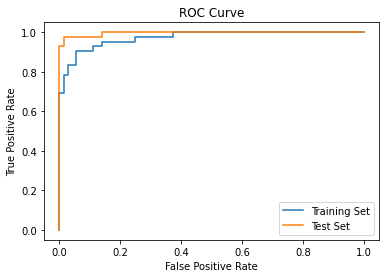

In [ ]:
train_fp, train_tp, train_thresholds = roc_curve(train_y,prob_train["Probility of label 1"] )
train_fp, train_tp, train_thresholds = roc_curve(test_y,prob_test["Probility of label 1"] )

plt.plot(train_fp, train_tp, label = "Training Set")
plt.plot(test_fp, test_tp, label = "Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='best')
plt.show()

iv): Spectral Clustering 

In [ ]:
train_results = []
test_results = []


for i in range(30):
    print("Iteration {}:".format(i+1))
    train_x, train_y, test_x, test_y = randomSplit(data_df, label_df)
    scaler = MinMaxScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    train_y = np.array(train_y)
    test_y = np.array(test_y)

    model = SpectralClustering(n_clusters=2, gamma=1, random_state=i)
    train_label = model.fit_predict(train_x)
    test_label = model.fit_predict(test_x)
    # find the majority of each cluster 
    cluster_zero_index = np.where(train_label == 0)
    cluster_one_index = np.where(train_label == 1)
    cluster_zero_y = train_y[cluster_zero_index]
    cluster_one_y = train_y[cluster_one_index]
    majority_zero = np.argmax(np.bincount(cluster_zero_y))
    majority_one = np.argmax(np.bincount(cluster_one_y))

    # assign the label of samples in each cluster according to the majority polling 
    train_predict = np.ones(train_y.shape)
    train_predict[cluster_zero_index] = majority_zero
    train_predict[cluster_one_index] = majority_one

    # test prediction 
    test_predict = np.ones(test_y.shape)
    test_predict[np.where(test_label == 0)] = majority_zero
    test_predict[np.where(test_label == 1)] = majority_one

    train_result = kmeanComputeResults(train_y, train_predict)
    test_result = kmeanComputeResults(test_y, test_predict)
    print("Train accuracy = {:.4f}, test accuracy = {:.4f}. \n".format(train_result[0], test_result[0]))
    train_results.append(train_result)
    test_results.append(test_result)

Iteration 1:
Train accuracy = 0.8571, test accuracy = 0.8246. 

Iteration 2:
Train accuracy = 0.8549, test accuracy = 0.0965. 

Iteration 3:
Train accuracy = 0.8549, test accuracy = 0.1140. 

Iteration 4:
Train accuracy = 0.8725, test accuracy = 0.1842. 

Iteration 5:
Train accuracy = 0.8637, test accuracy = 0.8070. 

Iteration 6:
Train accuracy = 0.8901, test accuracy = 0.7982. 

Iteration 7:
Train accuracy = 0.8681, test accuracy = 0.7632. 

Iteration 8:
Train accuracy = 0.8505, test accuracy = 0.8860. 

Iteration 9:
Train accuracy = 0.8440, test accuracy = 0.8860. 

Iteration 10:
Train accuracy = 0.8549, test accuracy = 0.7281. 

Iteration 11:
Train accuracy = 0.8527, test accuracy = 0.1316. 

Iteration 12:
Train accuracy = 0.8527, test accuracy = 0.8772. 

Iteration 13:
Train accuracy = 0.8352, test accuracy = 0.8772. 

Iteration 14:
Train accuracy = 0.8418, test accuracy = 0.0789. 

Iteration 15:
Train accuracy = 0.8549, test accuracy = 0.6754. 

Iteration 16:
Train accuracy = 0.8

In [ ]:
train_table = pd.DataFrame(train_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])
test_table = pd.DataFrame(test_results, columns = ["Accuracy", "Precision", "Recall", "F1", "AUC"])

In [ ]:
train_4 = train_table.agg(["mean"])
train_4

,Accuracy,Precision,Recall,F1,AUC
mean,0.860073,0.981773,0.637451,0.772339,0.815158


In [ ]:
test_4 = test_table.agg(["mean"])
test_4

,Accuracy,Precision,Recall,F1,AUC
mean,0.553509,0.657835,0.469048,0.501289,0.535913


In [ ]:
# compute confusion matrix and draw the roc curve 
# pick the model from the last iteration of the Monte-Carlo simulation 
train_conf = confusion_matrix(train_y, train_predict)
test_conf = confusion_matrix(test_y, test_predict)
train_conf = pd.DataFrame(train_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])
test_conf = pd.DataFrame(test_conf, columns = ["Predict B", "Predict M"], index= ["Actual B", "Actual M"])

In [ ]:
train_conf

,Predict B,Predict M
Actual B,284,1
Actual M,69,101


In [ ]:
test_conf

,Predict B,Predict M
Actual B,72,0
Actual M,5,37


In [ ]:
def getROC(conf):
    tpr = conf[1][1]/(conf[1][1]+conf[1][0])
    fpr = conf[0][1]/(conf[0][1]+conf[0][0])
    return tpr, fpr 

In [ ]:
# vary the threshold to get the ROC curve 
# if number of samples with true label of 1 >= threshold, assign class 1 to all samples in the cluster, else assign 0
train_tprs, train_fprs, test_tprs, test_fprs = [], [], [], []
for threshold in np.linspace(0,1,11):
    cluster_one = np.where(train_label == 1)
    cluster_zero = np.where(train_label == 0)
    # count number of 1's in both cluster
    cluster_one_n = np.bincount(train_y[cluster_one])[1]
    cluster_zero_n = np.bincount(train_y[cluster_zero])[1]
    # compare to the threshold 
    majority_one = 1 if cluster_one_n/len(cluster_one[0]) >= threshold else 0
    majority_zero = 1 if cluster_one_n/len(cluster_zero[0]) >= threshold else 0
    train_predict = [majority_one if i in cluster_one[0] else majority_zero for i in range(len(train_x))]
    test_predict = [majority_one if j in cluster_one[0] else majority_zero for j in range(len(test_x))]
    train_conf = confusion_matrix(train_y, train_predict)
    test_conf = confusion_matrix(test_y, test_predict)
    train_tpr, train_fpr = getROC(train_conf)
    test_tpr, test_fpr = getROC(test_conf)

    train_tprs.append(train_tpr)
    train_fprs.append(train_fpr)
    test_tprs.append(test_tpr)
    test_fprs.append(test_fpr)




In [ ]:
train_fprs = np.array(train_fprs)
train_tprs = np.array(train_tprs)
test_fprs = np.array(test_fprs)
test_tprs = np.array(test_tprs)

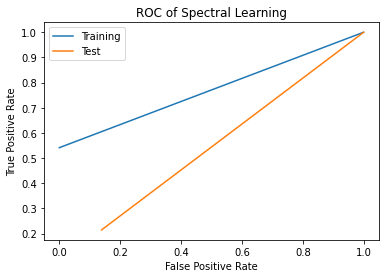

In [ ]:
plt.plot(train_fprs, train_tprs, label = "Training")
plt.plot(test_fprs, test_tprs, label = "Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of Spectral Learning")
plt.legend(loc="best")
plt.show()

v): Compare resutls 

In [ ]:
train = pd.concat([train_1, train_2, train_3, train_4])
train.index = ["Supervised", "Semi-supervised","Unsupervised", "Spectral Learning"]

In [ ]:
train

,Accuracy,Precision,Recall,F1,AUC
Supervised,0.986081,0.991802,0.970784,0.981167,0.982994
Semi-supervised,0.975897,0.983207,0.951961,0.967195,0.971068
Unsupervised,0.908791,0.921784,0.826471,0.871337,0.892183
Spectral Learning,0.860073,0.981773,0.637451,0.772339,0.815158


In [ ]:
test=pd.concat([test_1, test_2, test_3, test_4])
test.index = ["Supervised", "Semi-supervised","Unsupervised", "Spectral Learning"]

In [ ]:
test

,Accuracy,Precision,Recall,F1,AUC
Supervised,0.971637,0.979112,0.943651,0.960654,0.965807
Semi-supervised,0.965789,0.982229,0.924603,0.952033,0.957209
Unsupervised,0.916959,0.930400,0.838095,0.881166,0.900529
Spectral Learning,0.553509,0.657835,0.469048,0.501289,0.535913


***Comment:***


*   supervised learning on the entire dataset performs slightly better than semi-supervised learning on half of the dataset. Since we use predicted labels as ground thruth when train the semi-supervised model, errors may get introduced to the dataset as we train the model. 
*   supervised and semi-supervised learning outperform unsupervised and spectral learning. Clustering is not very good classifier and does not deliver stable results. 
* all of the models are better at predicting class 0 than class 1 since this dataset is unbalanced. We can use techniques such as SMOTE to solve this problem. 



# Reference:
1. https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python